In [1]:
#LSTM을 활용하여 60일 이전 데이터를 기반으로 주식 가격 예측(APPLE)

In [2]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [3]:
#DataFrame형태로 데이터 획득
df = web.DataReader('AAPL', data_source='yahoo', start='2013-01-01',end='2021-02-15')
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2013-01-02,19.821428,19.343929,19.779285,19.608213,560518000.0,17.039789
2013-01-03,19.631071,19.321428,19.567142,19.360714,352965200.0,16.824715
2013-01-04,19.236786,18.779642,19.177500,18.821428,594333600.0,16.356062
2013-01-07,18.903570,18.400000,18.642857,18.710714,484156400.0,16.259851
2013-01-08,18.996071,18.616072,18.900356,18.761070,458707200.0,16.303608
...,...,...,...,...,...,...
2021-02-08,136.960007,134.919998,136.029999,136.910004,71297200.0,136.910004
2021-02-09,137.880005,135.850006,136.619995,136.009995,76774200.0,136.009995
2021-02-10,136.990005,134.399994,136.479996,135.389999,73046600.0,135.389999


In [4]:
#데이터 개수 및 형태확인
df.shape

(2044, 6)

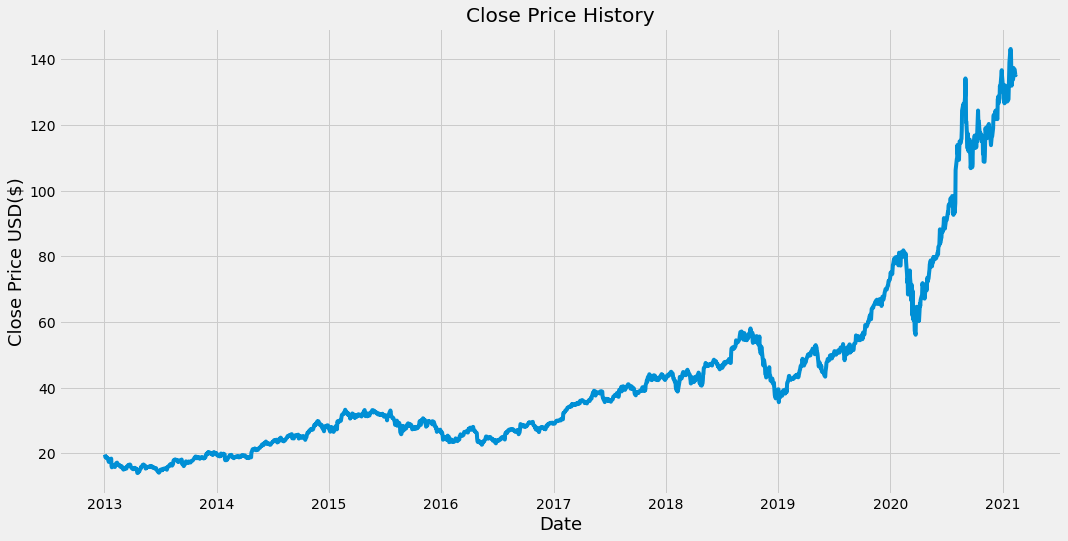

In [5]:
#closing price(마감 가격) 시각화
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD($)', fontsize=18)
plt.show()

In [6]:
#이용할 'close'속성만을 이용하여 새로운 Dataframe 형성
data=df.filter(['Close'])

#df를 numpy array로 변환
dataset = data.values

training_data_len = math.ceil(len(dataset) * .8)
training_data_len

1636

In [7]:
#0~1 사이로 데이터 크기조정
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.04380933],
       [0.04189388],
       [0.03772025],
       ...,
       [0.93986647],
       [0.93785432],
       [0.93971165]])

In [8]:
train_data = scaled_data[0:training_data_len,:]

#x_train / y_train 분류
x_train = []
y_train = []

for i in range(60,len(train_data)):
  x_train.append(train_data[i-60:i,0])
  y_train.append(train_data[i,0])
  if(i<=60):
    print(x_train)
    print(y_train)
    print()

[array([0.04380933, 0.04189388, 0.03772025, 0.03686341, 0.03725313,
       0.0349839 , 0.03675563, 0.03586838, 0.03074117, 0.02636576,
       0.03194073, 0.03099821, 0.03025747, 0.03157589, 0.03412982,
       0.01657569, 0.01364032, 0.0163905 , 0.0187233 , 0.01832529,
       0.01795492, 0.01743805, 0.01431474, 0.01860446, 0.01846902,
       0.02147349, 0.02334195, 0.02471012, 0.02138504, 0.02113904,
       0.02102296, 0.01924571, 0.01919871, 0.01611963, 0.01534846,
       0.01666137, 0.01444741, 0.01615279, 0.01493663, 0.01406045,
       0.0110394 , 0.00815932, 0.01122458, 0.00970992, 0.0110698 ,
       0.0113849 , 0.01308475, 0.01047554, 0.01045343, 0.0116005 ,
       0.01468511, 0.01801849, 0.01767853, 0.01701239, 0.01719205,
       0.01972941, 0.02019099, 0.01951658, 0.01701239, 0.01440871])]
[0.010608216319641275]



In [9]:
#x_train / y_train np.array로 변경
x_train, y_train = np.array(x_train), np.array(y_train)

In [10]:
x_train = np.reshape(x_train,(x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(1576, 60, 1)

In [11]:
#LSTM 모델링
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [12]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [13]:
model.fit(x_train,y_train,batch_size=1,epochs=1)

1576/1576 [==============================] - 17s 6ms/step - loss: 9.1444e-04


In [14]:
#test dataset 생성
test_data = scaled_data[training_data_len-60:,:]

x_test = []
y_test = dataset[training_data_len:,:]

for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])

In [15]:
#x_test np.array 변경후 형태맞추기
x_test = np.array(x_test)

In [17]:
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

In [18]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [19]:
#root mean squared error(RMSE)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

2.9732355977974687

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


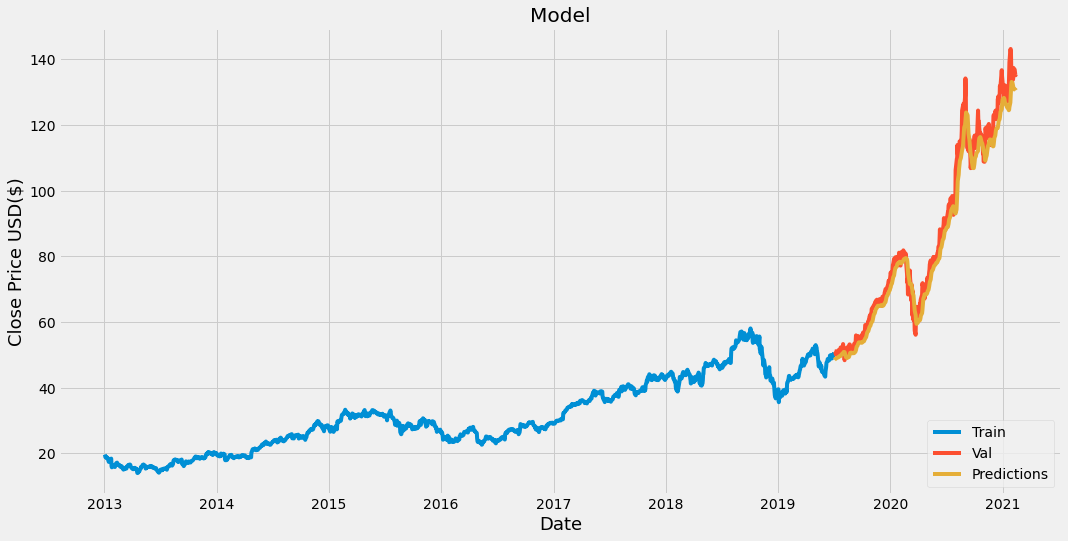

In [21]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train','Val','Predictions'],loc='lower right')
plt.show()

In [22]:
valid

,Close,Predictions
Date,,
2019-07-03,51.102501,48.445393
2019-07-05,51.057499,48.651043
2019-07-08,50.005001,48.863255
2019-07-09,50.310001,48.959503
2019-07-10,50.807499,49.011890
...,...,...
2021-02-08,136.910004,130.809601
2021-02-09,136.009995,130.824341
2021-02-10,135.389999,130.798904


In [26]:
apple_quote = web.DataReader('AAPL',data_source='yahoo',start='2012-01-01',end='2021-02-15')
new_df = apple_quote.filter(['Close'])
last_60_days = new_df[-60:].values
last_60_days_scaled = scaler.transform(last_60_days)

X_test = []
X_test.append(last_60_days_scaled)
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

pred_price = model.predict(X_test)
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

[[130.41331]]


In [30]:
apple_quote2 = web.DataReader('AAPL',data_source='yahoo',start='2021-02-10',end='2021-02-10')
print(apple_quote2['Close'])

Date
2021-02-10    135.389999
Name: Close, dtype: float64
